# WSI - Ćwiczenie 7

*Autor: Maksymilian Nowak*

### Cel ćwiczenia

Celem ćwiczenia jest implementacja narzędzia do wnioskowania przy użyciu sieci Bayesa i zademonstrowanie jego możliwości na następującym przykładzie:
- Mamy w domu zamontowany alarm przeciwwłamaniowy.
- Czasem alarm uruchamia się w przypadku niewielkich trzęsień ziemi.
- Umówiliśmy się z sąsiadami, aby dzwonili gdy usłyszą alarm.
    - Jan dzwoni do nas zawsze gdy usłyszy sygnał alarmu - czasem myli go nawet z innymi dźwiękami.
    - Magda dzwoni rzadziej - w domu lubi słuchać dość głośnej muzyki.
    
**Pytanie: Jak ocenimy szanse na to, że było włamanie w zależności od tego kto zadzwonił?**

#### Założenia

1. Wnioskowanie będzie stosowało algorytm MCMC z próbkowaniem Gibbsa,
2. Metoda/funkcja do wnioskowania będzie mieć 3 parametry wejściowe:
    1. Dowody - zaobserwowane wartości wybranych węzłów sieci,
    2. Zapytanie - określenie, dla której zmiennej chcemy wykonać obliczenia,
    3. Liczba iteracji algorytmu MCMC,
    
    oraz będzie zwracała zaktualizowaną tabelę prawdopodobieństw dla zmiennej z zapytania,
3. Można przyjąć założenie, że wszystkie zmienne losowe są binarne,
4. Eksperymenty powinny dotyczyć tego, jak zmieniają się wyniki wnioskowania i czas obliczeń wraz ze zwiększaniem liczby iteracji.


## Implementacja algorytmu

### Sieć Bayesa

Przed implementacją narzędzia do wnioskowania należy zdefiniować struktury sieci Bayesa, na której będzie działał algorytm.

Słownik `nodes` zawiera informacje o poszczególnych węzłach sieci - ich nazwę oraz listę rodziców.

Słownik `probabilities` zawiera informacje o wartości prawdopodobieństw zdarzeń dla każdego z węzłów - jeśli dany węzeł nie posiada rodziców, do każdej z wartości węzła (w tym przypadku `True` i `False`) przypisywane jest prawdopodobieństwo. Natomiast jeśli węzeł posiada rodziców, do każdej z możliwych wartości przypisany jest słownik reprezentujący tabelę prawdopodobieństw warunkowych z kluczami w postaci krotki z konkretnymi wartościami rodziców - np. następujący fragment słownika:
```python
    'Alarm': {
            True: {
                (True, True): 0.95,
```
oznacza, że prawdopodobieństwo zdarzenia, że załączy się alarm, gdy wartości rodziców (włamanie oraz trzęsienie ziemi) są `True`, wynosi 0.95.

In [31]:
nodes = {
    'Burglary': [],
    'Earthquake': [],
    'Alarm': ['Burglary', 'Earthquake'],
    'JanCalls': ['Alarm'],
    'MagdaCalls': ['Alarm']
}

probabilities = {
    'Burglary': {
        True: 0.01,
        False: 0.99
    },
    'Earthquake': {
        True: 0.02,
        False: 0.98
    },
    'Alarm': {
        True: {
            (True, True): 0.95,
            (True, False): 0.94,
            (False, True): 0.29,
            (False, False): 0.001
        },
        False: {
            (True, True): 0.05,
            (True, False): 0.06,
            (False, True): 0.71,
            (False, False): 0.999
        }
    },
    'JanCalls': {
        True: {
            (True,): 0.90,
            (False,): 0.05
        },
        False: {
            (True,): 0.10,
            (False,): 0.95
        }
    },
    'MagdaCalls': {
        True: {
            (True,): 0.70,
            (False,): 0.01
        },
        False: {
            (True,): 0.30,
            (False,): 0.99
        }
    }
}

Poniższe klasy reprezentują odpowiednio węzeł oraz całą sieć Bayesa.

Węzeł przechowuje nazwę, listę rodziców, dzieci oraz aktualną wartość (początkowo ustawianą na `None`).

Klasa sieci Bayesa przechowuję listę węzłów, inicjowanych na podstawie podawanej jako argument wejściowy struktury oraz strukturę prawdopodobieństw sieci. Dodatkowo w klasie dostępne są metody pozwalające na obliczenie prawdopodobieństwa warunkowego danego węzła oraz otoczki Markowa danego węzła.

In [32]:
class BayesianNode:
    def __init__(self, name):
        self.name = name
        self.parents = []
        self.children = []
        self.value = None
    
    def __str__(self):
        return self.name
    
    def add_parent(self, parent):
        self.parents.append(parent)
    
    def add_child(self, child):
        self.children.append(child)
    
    def set_value(self, value):
        self.value = value

In [33]:
class BayesianNetwork:
    def __init__(self, nodes_struct, probabilities):
        self.nodes = []
        self.probabilities = probabilities
        self.build(nodes_struct)
    
    def build(self, nodes_struct):
        for node_name in nodes_struct:
            node = BayesianNode(node_name)
            self.nodes.append(node)
        
        for node_name in nodes_struct:
            node = self.get_node(node_name)
            for parent_name in nodes_struct[node_name]:
                parent = self.get_node(parent_name)
                node.add_parent(parent)
                parent.add_child(node)
    
    def get_node(self, node_name):
        for node in self.nodes:
            if node.name == node_name:
                return node
        return None
    
    def conditional_prob(self, node_name, value, parent_values=None):
        node = self.get_node(node_name)
        prob_table = self.probabilities[node.name]
        if len(node.parents) == 0:
            return prob_table[value]
        else:
            return prob_table[value][parent_values]
    
    def markov_blanket_prob(self, node_name, value):
        node = self.get_node(node_name)
        node.set_value(value)

        # P(node | parents)
        if len(node.parents) > 0:
            prob = self.conditional_prob(node_name, value, tuple([parent.value for parent in node.parents]))
        else:
            prob = self.conditional_prob(node_name, value)
        children = node.children
        # P(children | children_parents)
        for child in children:
            prob *= self.conditional_prob(child.name, child.value, tuple([child_parent.value for child_parent in child.parents]))
        return prob

### Algorytm MCMC z próbkowaniem Gibbsa

Poniższa klasa jest implementacją algorytmu Markov Chain Monte Carlo wykorzystującego próbkowanie Gibbsa.

Klasa pobiera jako argument wejściowy sieć Bayesa, na której wykonywane będzie wnioskowanie. Z kolei metoda `run` wykonuje je - pobiera ona dowody w postaci słownika nazw węzłów z odpowiadającymi im wartościami oraz nazwę węzła, którego dotyczy zapytanie.
Następnie w sieci ustawiane są odpowiednie wartości węzłów będących dowodami, a pozostałe ustawiane są w sposób losowy. Potem inicjowany jest licznik wystąpień poszczególnych wartości węzła. W kolejnym kroku wykonywana jest pętla *błądząca* po sieci - ustawia ona wartości węzłów niebędących dowodami zgodnie z rozkładem prawdopodobieństwa warunkowego na podstawie otoczki Markowa danego węzła, a potem aktualizuje wartości licznika wystąpień wartości węzła zapytania. Na końcu uzyskane wystąpienia są normalizowane tak, aby były one rozkładem prawdopodobieństwa zmiennej zapytania.

In [34]:
import numpy as np

class Gibbs:
    def __init__(self, network):
        self.network = network
        self.counts = {}
    
    def run(self, evidence, query, iterations):
        # Ustalamy wartości początkowe zaobserwowanych zmiennych, pozostałe losujemy
        for node in self.network.nodes:
            if node.name in evidence:
                node.set_value(evidence[node.name])
            else:
                node.set_value(np.random.choice([True, False]))
        # Ustawiamy liczniki zaobserwowanych wartości zmiennej query
        self.counts = {True: 0, False: 0}
        # Błądzenie przypadkowe
        for _ in range(iterations):
            # Losujemy węzeł nienależący do dowodów
            not_evidence = [node for node in self.network.nodes if node.name not in evidence]
            node = np.random.choice(not_evidence)
            # Otoczka Markowa
            blanket_prob_true = self.network.markov_blanket_prob(node.name, True)
            blanket_prob_false = self.network.markov_blanket_prob(node.name, False)
            prob_true = blanket_prob_true / (blanket_prob_true + blanket_prob_false)
            prob_false = blanket_prob_false / (blanket_prob_true + blanket_prob_false)
            node.set_value(np.random.choice([True, False], p=[prob_true, prob_false]))
            # Aktualizacja liczników
            query_node = self.network.get_node(query)
            self.counts[query_node.value] += 1
        # Normalizujemy liczniki, aby uzyskać rozkład prawdopodobieństwa
        return {True: self.counts[True] / iterations, False: self.counts[False] / iterations}

## Testowanie działania algorytmu

Eksperymenty przeprowadzane są dla dwóch sytuacji:
1. Jakie jest prawdopodobieństwo tego, że Jan zadzwonił, jeśli wiadomo, że było włamanie, ale nie było trzęsienia ziemi
2. Jakie jest prawdopodobieństwo tego, że było włamanie, jeśli wiadomo, że Jan i Magda zadzwonili

Dla każdego przypadku badany jest wpływ liczby iteracji algorytmu MCMC na średnie uzyskiwane wyniki oraz czas obliczeń - algorytm uruchamiany jest po 100 razy dla każdej wartości liczby iteracji, będącej z zakresu $[100;5000]$ ze skokiem co 100 iteracji.

In [35]:
import matplotlib.pyplot as plt
import time

def plot(evidence, query):
    bn = BayesianNetwork(nodes, probabilities)
    gibbs = Gibbs(bn)
    iterations = np.linspace(100, 5000, 50)
    true_probs = []
    false_probs = []
    true_probs_std = []
    false_probs_std = []
    times = []
    for i in iterations:
        temp_false = []
        temp_true = []
        temp_times = []
        for _ in range(100):
            start = time.time()
            res = gibbs.run(evidence, query, int(i))
            end = time.time()
            temp_times.append(end - start)
            temp_false.append(res[False])
            temp_true.append(res[True])
        times.append(np.mean(temp_times))
        false_probs.append(np.mean(temp_false))
        true_probs.append(np.mean(temp_true))
        false_probs_std.append(np.std(temp_false))
        true_probs_std.append(np.std(temp_true))
    plt.plot(iterations, true_probs, label='True')
    plt.fill_between(iterations, np.array(true_probs) - np.array(true_probs_std), np.array(true_probs) + np.array(true_probs_std), alpha=0.5)
    plt.plot(iterations, false_probs, label='False')
    plt.fill_between(iterations, np.array(false_probs) - np.array(false_probs_std), np.array(false_probs) + np.array(false_probs_std), alpha=0.5)
    plt.xlabel('Liczba iteracji')
    plt.ylabel('Prawdopodobieństwo')
    plt.title(f'Próbkowanie Gibbsa dla {query} przy {evidence} - średnia z 100 prób, zakres iteracji od 100 do 5000')
    plt.legend()
    plt.show()
    plt.plot(iterations, times)
    plt.xlabel('Liczba iteracji')
    plt.ylabel('Czas wykonania')
    plt.title(f'Czas wykonania próbkowania Gibbsa dla {query} przy {evidence} - średnia z 100 prób, zakres iteracji od 100 do 5000')
    plt.show()

### Przypadek 1

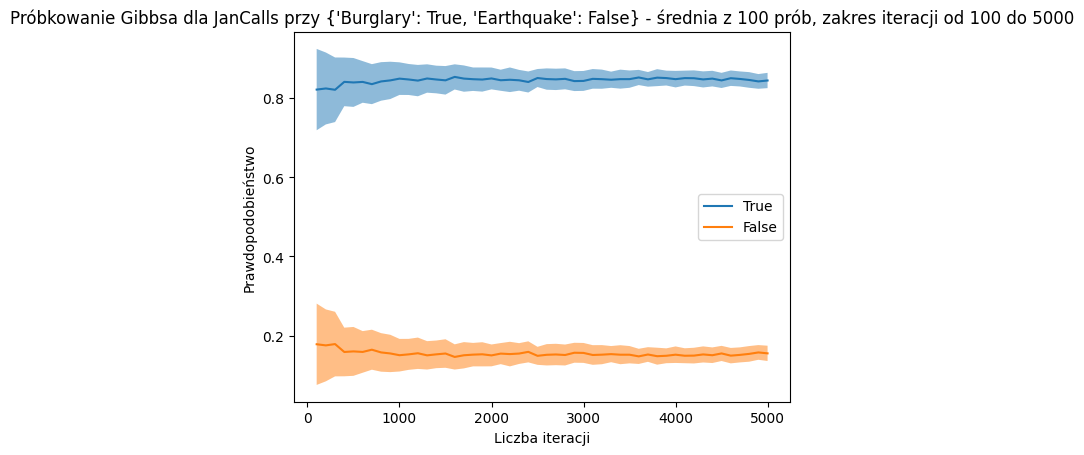

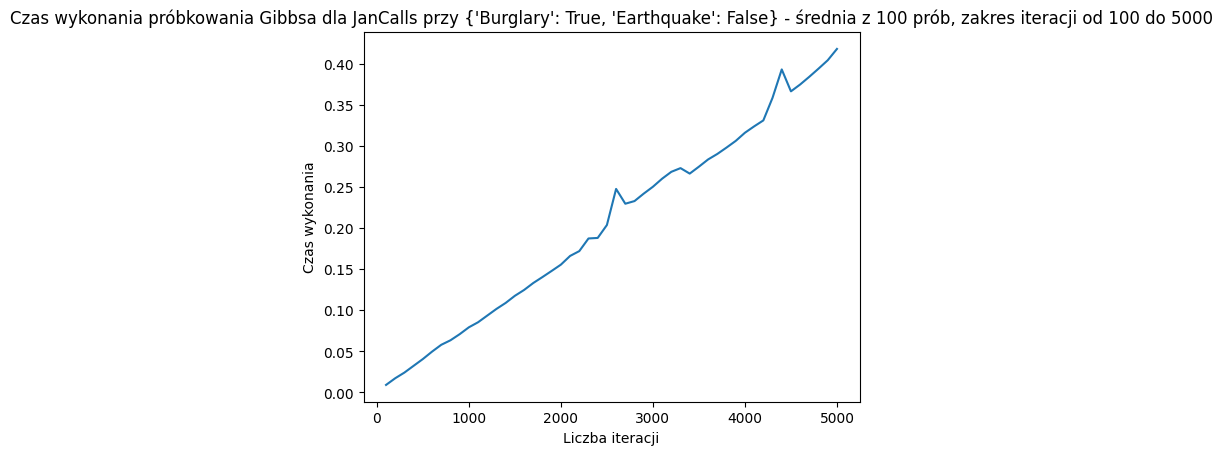

In [36]:
plot({'Burglary': True, 'Earthquake': False}, 'JanCalls')

### Przypadek 2

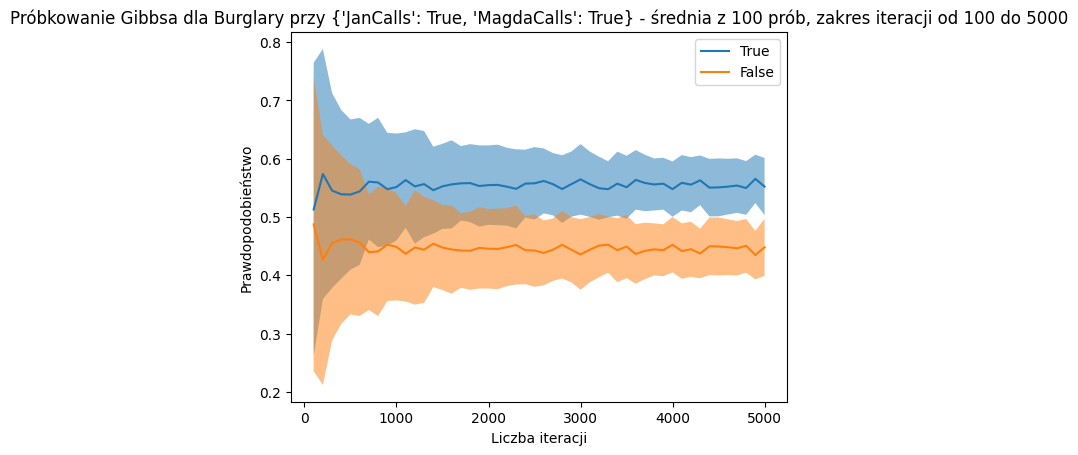

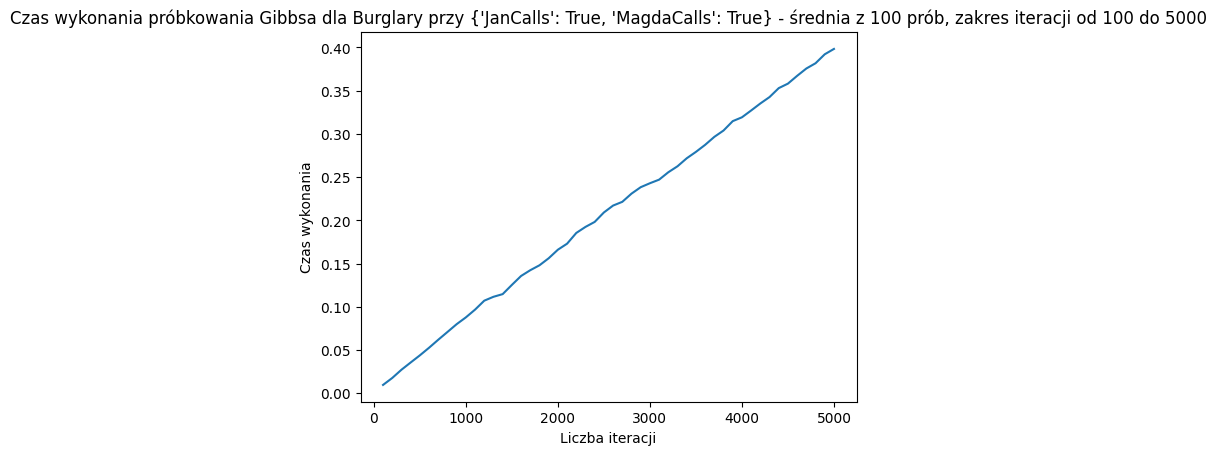

In [37]:
plot({'JanCalls': True, 'MagdaCalls': True}, 'Burglary')

### Wnioski

Można zauważyć, że o ile liczba iteracji nie wpływała na średni uzyskiwany wynik, to odchylenie standardowe uzyskiwanych rozkładów ulegało stopniowemu zmniejszaniu - było to najbardziej zauważalne dla pierwszego 1000 iteracji, dlatego małe wartości parametru liczby iteracji nie mogą zagwarantować dobrego wyniku wnioskowania.

Z kolei wzrost czasu wykonywania był liniowy - za wyjątkiem okazjonalych skoków wartości dla przypadku pierwszego.